In [3]:
import pandas as pd
import numpy as np

import time
from tqdm.notebook import tqdm

import os

import bertopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from IPython.display import clear_output

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score


## Import Data

In [4]:
data = pd.read_csv("cleaned_reviews.csv")

In [5]:
data.head()

,Unnamed: 0,restaurant_name,cleaned,word_count,review_rating,restaurant_label
0,0,entre_nous_creperie,come entre nous periodically past year seem se...,47,5.0,0
1,1,entre_nous_creperie,absolutely delicious menu lovely offer excepti...,42,5.0,0
2,2,entre_nous_creperie,thank much choose entre nous creperie recently...,45,5.0,0
3,3,entre_nous_creperie,lovely little french restaurant really authent...,45,4.5,0
4,4,entre_nous_creperie,dear rebecca thank much dining entre nous crep...,45,4.0,0


In [6]:
data.drop(columns=["Unnamed: 0"], inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40947 entries, 0 to 40946
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   restaurant_name   40947 non-null  object 
 1   cleaned           40946 non-null  object 
 2   word_count        40947 non-null  int64  
 3   review_rating     40947 non-null  float64
 4   restaurant_label  40947 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.6+ MB


In [8]:
data[data['cleaned'].isnull()]

,restaurant_name,cleaned,word_count,review_rating,restaurant_label
28025,pasta_brava_italian_restaurant,NaN,1,5.0,87


In [9]:
data = data[~data['cleaned'].isnull()]

In [10]:
data.rename(columns={'cleaned':'review_text'}, inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40946 entries, 0 to 40946
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   restaurant_name   40946 non-null  object 
 1   review_text       40946 non-null  object 
 2   word_count        40946 non-null  int64  
 3   review_rating     40946 non-null  float64
 4   restaurant_label  40946 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.9+ MB


In [12]:
data.reset_index(drop=True, inplace=True)

## Unsupervised

In [13]:
reviews = data[['review_text','restaurant_label']]

In [14]:
reviews.head()

,review_text,restaurant_label
0,come entre nous periodically past year seem se...,0
1,absolutely delicious menu lovely offer excepti...,0
2,thank much choose entre nous creperie recently...,0
3,lovely little french restaurant really authent...,0
4,dear rebecca thank much dining entre nous crep...,0


In [15]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [16]:
# Load a pre-trained BERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

df = reviews.copy()

# Get embeddings for each review_text
embeddings = model.encode(df['review_text'], convert_to_tensor=True)

# Manually set topics (you can customize this based on your needs)
topics = {'food': model.encode(['delicious food'], convert_to_tensor=True),
          'service': model.encode(['excellent service'], convert_to_tensor=True),
          'ambiance': model.encode(['pleasant ambiance'], convert_to_tensor=True),
         'authentic':model.encode(['authentic food'], convert_to_tensor=True)}

# Calculate similarity scores for each review_text with respect to each topic
scores = {topic: util.pytorch_cos_sim(embeddings, topics[topic]) for topic in topics}

# Display scores
for topic, score_matrix in scores.items():
    df[f'{topic}_score'] = score_matrix.max(dim=1).values.cpu().numpy()

df.head()

,review_text,restaurant_label,food_score,service_score,ambiance_score,authentic_score
0,come entre nous periodically past year seem se...,0,0.462757,0.427331,0.331545,0.492026
1,absolutely delicious menu lovely offer excepti...,0,0.448536,0.318372,0.282956,0.371091
2,thank much choose entre nous creperie recently...,0,0.430254,0.381057,0.289790,0.406790
3,lovely little french restaurant really authent...,0,0.416918,0.309187,0.258666,0.506409
4,dear rebecca thank much dining entre nous crep...,0,0.414757,0.294917,0.352158,0.438276


In [17]:
# the above scores are similarity scores

In [18]:
df.describe()

,restaurant_label,food_score,service_score,ambiance_score,authentic_score
count,40946.000000,40946.000000,40946.000000,40946.000000,40946.000000
mean,59.671103,0.400088,0.267942,0.243458,0.413295
std,44.794317,0.129123,0.107598,0.079995,0.106987
min,0.000000,-0.195335,-0.092848,-0.106955,-0.153411
25%,19.000000,0.330595,0.191868,0.191683,0.358629
50%,48.000000,0.420326,0.259301,0.243835,0.429649
75%,99.000000,0.491194,0.336181,0.294828,0.485154
max,146.000000,0.817710,0.753817,0.717879,0.749839


In [19]:
# individual reviews level

In [20]:
# obtaining the average score of each review ot have an overall score of the columns

columns_to_average = ['food_score', 'service_score', 'ambiance_score', 'authentic_score']

# Calculate the average cosine similarity for each row
df['overall_score'] = df[columns_to_average].mean(axis=1)

df.head()

,review_text,restaurant_label,food_score,service_score,ambiance_score,authentic_score,overall_score
0,come entre nous periodically past year seem se...,0,0.462757,0.427331,0.331545,0.492026,0.428415
1,absolutely delicious menu lovely offer excepti...,0,0.448536,0.318372,0.282956,0.371091,0.355239
2,thank much choose entre nous creperie recently...,0,0.430254,0.381057,0.289790,0.406790,0.376973
3,lovely little french restaurant really authent...,0,0.416918,0.309187,0.258666,0.506409,0.372795
4,dear rebecca thank much dining entre nous crep...,0,0.414757,0.294917,0.352158,0.438276,0.375027


In [21]:
# restaurant level

In [22]:
grouped_by_restaurant = df.groupby('restaurant_label')[['food_score', 'service_score', 'ambiance_score', 'authentic_score', 'overall_score']].mean()

In [23]:
grouped_by_restaurant.describe()

,food_score,service_score,ambiance_score,authentic_score,overall_score
count,147.000000,147.000000,147.000000,147.000000,147.000000
mean,0.408964,0.249337,0.236037,0.416718,0.327764
std,0.034794,0.040690,0.030276,0.032178,0.025112
min,0.275318,0.150029,0.139349,0.285893,0.247341
25%,0.391556,0.219220,0.213627,0.401256,0.311935
50%,0.413321,0.248320,0.239082,0.419201,0.329962
75%,0.430648,0.277528,0.255216,0.436425,0.344995
max,0.482618,0.376933,0.318639,0.491964,0.380185


In [24]:
grouped_by_restaurant.head()

,food_score,service_score,ambiance_score,authentic_score,overall_score
restaurant_label,,,,,
0,0.350580,0.279037,0.281549,0.373190,0.321089
1,0.470979,0.258552,0.284878,0.467595,0.370501
2,0.388332,0.216109,0.194512,0.393876,0.298207
3,0.415788,0.181683,0.197800,0.401272,0.299136
4,0.440921,0.257636,0.246050,0.449827,0.348608


## Supervised

- vectorize the reviews
- set X and y
- train-test split
- predict the average_cosine_similarity of a review
- metric: rmse

In [25]:
## Classification

In [26]:
df.head()

,review_text,restaurant_label,food_score,service_score,ambiance_score,authentic_score,overall_score
0,come entre nous periodically past year seem se...,0,0.462757,0.427331,0.331545,0.492026,0.428415
1,absolutely delicious menu lovely offer excepti...,0,0.448536,0.318372,0.282956,0.371091,0.355239
2,thank much choose entre nous creperie recently...,0,0.430254,0.381057,0.289790,0.406790,0.376973
3,lovely little french restaurant really authent...,0,0.416918,0.309187,0.258666,0.506409,0.372795
4,dear rebecca thank much dining entre nous crep...,0,0.414757,0.294917,0.352158,0.438276,0.375027


In [27]:
df.describe()

,restaurant_label,food_score,service_score,ambiance_score,authentic_score,overall_score
count,40946.000000,40946.000000,40946.000000,40946.000000,40946.000000,40946.000000
mean,59.671103,0.400088,0.267942,0.243458,0.413295,0.331196
std,44.794317,0.129123,0.107598,0.079995,0.106987,0.076071
min,0.000000,-0.195335,-0.092848,-0.106955,-0.153411,-0.059397
25%,19.000000,0.330595,0.191868,0.191683,0.358629,0.288140
50%,48.000000,0.420326,0.259301,0.243835,0.429649,0.339152
75%,99.000000,0.491194,0.336181,0.294828,0.485154,0.383006
max,146.000000,0.817710,0.753817,0.717879,0.749839,0.594669


In [28]:
# 1 being promoter and 0 being detractor

df['sentiment'] = df['overall_score'].apply(lambda x: '1' if x >= 0.3 else '0')

In [29]:
df.head()

,review_text,restaurant_label,food_score,service_score,ambiance_score,authentic_score,overall_score,sentiment
0,come entre nous periodically past year seem se...,0,0.462757,0.427331,0.331545,0.492026,0.428415,1
1,absolutely delicious menu lovely offer excepti...,0,0.448536,0.318372,0.282956,0.371091,0.355239,1
2,thank much choose entre nous creperie recently...,0,0.430254,0.381057,0.289790,0.406790,0.376973,1
3,lovely little french restaurant really authent...,0,0.416918,0.309187,0.258666,0.506409,0.372795,1
4,dear rebecca thank much dining entre nous crep...,0,0.414757,0.294917,0.352158,0.438276,0.375027,1


In [43]:
# saving this for use in another notebook
# df.to_csv('review_sentiment.csv')

In [30]:
df['sentiment'].value_counts(normalize=True)

sentiment
1    0.701583
0    0.298417
Name: proportion, dtype: float64

In [31]:
X = df['review_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
## Under and Oversampling

In [63]:
def train_and_evaluate(X_train, y_train, resampler, classifier, vectorizer, param_grid, X_test, y_test):
     # Vectorize the text
    X_train_vectorized = vectorizer.fit_transform(X_train)
    
    # Apply resampling to the training data
    X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_vectorized, y_train)
    
    # Set up the pipeline with resampler, classifier, and vectorizer
    pipeline = Pipeline([
        ('classifier', classifier)
    ])

    # Perform GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, error_score='raise')
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the train set
    y_pred_train = grid_search.predict(X_train_resampled)

    
    # Make predictions on the test set
    X_test_vectorized = vectorizer.transform(X_test)
    y_pred = grid_search.predict(X_test_vectorized)

    # Evaluate the model
    f1_train = round(f1_score(y_train_resampled, y_pred_train, pos_label='1'),5)
    f1_test = round(f1_score(y_test, y_pred, pos_label='1'),5)
    recall_train = round(recall_score(y_train_resampled, y_pred_train, pos_label='1'),5)
    recall_test = round(recall_score(y_test, y_pred, pos_label='1'),5)
    precision_train = round(precision_score(y_train_resampled, y_pred_train, pos_label='1'),5)
    precision_test = round(precision_score(y_test, y_pred, pos_label='1'),5)
    classification_rep = classification_report(y_test, y_pred)

    
    details = {'resampler': resampler, 'vectorizer':vectorizer,'classifier': classifier, 'best_parameters':grid_search.best_params_,
               'f1_train': f1_train, 'f1_test': f1_test,
              'recall_train':recall_train, 'recall_test':recall_test,
              'precision_train':precision_train,'precision_test':precision_test}

    return details, classification_rep

    # print(f"F1 score: {f1:.2f}")
    # print("Classification Report:\n", classification_rep)

In [51]:
# def train_and_evaluate(X_train, y_train, resampler, classifier, vectorizer, param_grid, X_test, y_test):
#     # Vectorize the text
#     X_train_vectorized = vectorizer.fit_transform(X_train)

#     # Apply resampling to the training data
#     X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_vectorized, y_train)

#     # Set up the pipeline with resampler, classifier, and vectorizer
#     pipeline = Pipeline([
#         ('classifier', classifier)
#     ])

#     # Perform GridSearchCV
#     with tqdm(total=100, desc="Grid Search") as pbar:
#         grid_search = GridSearchCV(pipeline, param_grid, cv=5, error_score='raise')
#         grid_search.fit(X_train_resampled, y_train_resampled)
#         pbar.update(50)

#     # Make predictions on the train set
#     y_pred_train = grid_search.predict(X_train_resampled)

#     # Make predictions on the test set
#     X_test_vectorized = vectorizer.transform(X_test)
#     y_pred = grid_search.predict(X_test_vectorized)

#     # Evaluate the model
#     f1_train = round(f1_score(y_train_resampled, y_pred_train, pos_label='1'), 5)
#     f1_test = round(f1_score(y_test, y_pred, pos_label='1'), 5)
#     recall_train = round(recall_score(y_train_resampled, y_pred_train, pos_label='1'), 5)
#     recall_test = round(recall_score(y_test, y_pred, pos_label='1'), 5)
#     precision_train = round(precision_score(y_train_resampled, y_pred_train, pos_label='1'), 5)
#     precision_test = round(precision_score(y_test, y_pred, pos_label='1'), 5)
#     classification_rep = classification_report(y_test, y_pred)

#     details = {
#         'resampler': resampler,
#         'vectorizer': vectorizer,
#         'classifier': classifier,
#         'best_parameters': grid_search.best_params_,
#         'f1_train': f1_train,
#         'f1_test': f1_test,
#         'recall_train': recall_train,
#         'recall_test': recall_test,
#         'precision_train': precision_train,
#         'precision_test': precision_test
#     }

#     return details, classification_rep


### Multinomial Naive Bayes

In [34]:
Pipeline([
        ('vectorizer', CountVectorizer()),
        ('classifier', MultinomialNB()),
    ]).get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()), ('classifier', MultinomialNB())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'classifier': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'classifier__alpha': 1.0,
 'classifier__class_prior': None,
 'classifier__fit_prior': True,
 'classifier__force_alpha': 'warn'}

In [35]:
param_grid = {
    # 'vectorizer__ngram_range':[(1,1),(1,2),(2,2)],
    # 'vectorizer__max_features': [1000, 1800, 2000, 4000],
    'classifier__alpha': [0.1, 1, 5, 10]
            
}

nb_cvec = train_and_evaluate(X_train, y_train, SMOTE(random_state=42), MultinomialNB(), CountVectorizer(ngram_range=(1,1)), param_grid, X_test, y_test)

details_nb_cvec, classification_report_nb_cvec = nb_cvec

In [36]:
print(classification_report_nb_cvec)
details_df = pd.DataFrame([details_nb_cvec])
details_df

              precision    recall  f1-score   support

           0       0.65      0.70      0.67      2430
           1       0.87      0.84      0.85      5760

    accuracy                           0.80      8190
   macro avg       0.76      0.77      0.76      8190
weighted avg       0.80      0.80      0.80      8190



,resampler,vectorizer,classifier,best_parameters,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,SMOTE(random_state=42),CountVectorizer(),MultinomialNB(),{'classifier__alpha': 1},0.83255,0.8546,0.88035,0.84028,0.78968,0.86941


In [37]:
param_grid = {
    'classifier__alpha': [0.1, 1, 5, 10]
            
}

nb_tfid = train_and_evaluate(X_train, y_train, SMOTE(random_state=42), MultinomialNB(), TfidfVectorizer(ngram_range=(1,1)), param_grid, X_test, y_test)

details_nb_tfid, classification_report_nb_tfid = nb_tfid

In [38]:
print(classification_report_nb_tfid)
new_details_df = pd.DataFrame([details_nb_tfid])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)
details_df

              precision    recall  f1-score   support

           0       0.58      0.70      0.63      2430
           1       0.86      0.79      0.82      5760

    accuracy                           0.76      8190
   macro avg       0.72      0.74      0.73      8190
weighted avg       0.78      0.76      0.77      8190



,resampler,vectorizer,classifier,best_parameters,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,SMOTE(random_state=42),CountVectorizer(),MultinomialNB(),{'classifier__alpha': 1},0.83255,0.85460,0.88035,0.84028,0.78968,0.86941
1,SMOTE(random_state=42),TfidfVectorizer(),MultinomialNB(),{'classifier__alpha': 0.1},0.93941,0.82287,0.93020,0.78837,0.94879,0.86053


### DecisionTree

In [39]:
Pipeline([
        ('vectorizer', CountVectorizer()),
        ('classifier', DecisionTreeClassifier()),
    ]).get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()),
  ('classifier', DecisionTreeClassifier())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'classifier': DecisionTreeClassifier(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': None,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier_

In [40]:
param_grid = {
    'classifier__ccp_alpha': [0.1, 1, 10],
 'classifier__max_depth': [30, 50, 80]        
}

dt_cvec = train_and_evaluate(X_train, y_train, SMOTE(random_state=42), DecisionTreeClassifier(), CountVectorizer(ngram_range=(1,2)), param_grid, X_test, y_test)

details_dt_cvec, classification_report_dt_cvec = dt_cvec

In [41]:
print(classification_report_dt_cvec)
new_details_df = pd.DataFrame([details_dt_cvec])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

              precision    recall  f1-score   support

           0       0.50      0.63      0.56      2430
           1       0.82      0.74      0.78      5760

    accuracy                           0.70      8190
   macro avg       0.66      0.68      0.67      8190
weighted avg       0.73      0.70      0.71      8190



In [42]:
details_df

,resampler,vectorizer,classifier,best_parameters,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,SMOTE(random_state=42),CountVectorizer(),MultinomialNB(),{'classifier__alpha': 1},0.83255,0.85460,0.88035,0.84028,0.78968,0.86941
1,SMOTE(random_state=42),TfidfVectorizer(),MultinomialNB(),{'classifier__alpha': 0.1},0.93941,0.82287,0.93020,0.78837,0.94879,0.86053
2,SMOTE(random_state=42),"CountVectorizer(ngram_range=(1, 2))",DecisionTreeClassifier(),"{'classifier__ccp_alpha': 0.1, 'classifier__ma...",0.75335,0.77795,0.72665,0.73628,0.78209,0.82462


In [44]:
param_grid = {
    'classifier__ccp_alpha': [0.1, 1, 10],
 'classifier__max_depth': [30, 50, 80]        
}

dt_tfid = train_and_evaluate(X_train, y_train, SMOTE(random_state=42), DecisionTreeClassifier(), TfidfVectorizer(ngram_range=(1,2)), param_grid, X_test, y_test)

details_dt_tfid, classification_report_dt_tfid = dt_tfid

In [45]:
print(classification_report_dt_tfid)
new_details_df = pd.DataFrame([details_dt_tfid])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

              precision    recall  f1-score   support

           0       0.30      1.00      0.46      2430
           1       0.00      0.00      0.00      5760

    accuracy                           0.30      8190
   macro avg       0.15      0.50      0.23      8190
weighted avg       0.09      0.30      0.14      8190



In [46]:
details_df

,resampler,vectorizer,classifier,best_parameters,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,SMOTE(random_state=42),CountVectorizer(),MultinomialNB(),{'classifier__alpha': 1},0.83255,0.85460,0.88035,0.84028,0.78968,0.86941
1,SMOTE(random_state=42),TfidfVectorizer(),MultinomialNB(),{'classifier__alpha': 0.1},0.93941,0.82287,0.93020,0.78837,0.94879,0.86053
2,SMOTE(random_state=42),"CountVectorizer(ngram_range=(1, 2))",DecisionTreeClassifier(),"{'classifier__ccp_alpha': 0.1, 'classifier__ma...",0.75335,0.77795,0.72665,0.73628,0.78209,0.82462
3,SMOTE(random_state=42),"TfidfVectorizer(ngram_range=(1, 2))",DecisionTreeClassifier(),"{'classifier__ccp_alpha': 0.1, 'classifier__ma...",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [47]:
details_dt_tfid

{'resampler': SMOTE(random_state=42),
 'vectorizer': TfidfVectorizer(ngram_range=(1, 2)),
 'classifier': DecisionTreeClassifier(),
 'best_parameters': {'classifier__ccp_alpha': 0.1,
  'classifier__max_depth': 30},
 'f1_train': 0.0,
 'f1_test': 0.0,
 'recall_train': 0.0,
 'recall_test': 0.0,
 'precision_train': 0.0,
 'precision_test': 0.0}

### Extratree

In [55]:
Pipeline([
        ('vectorizer', CountVectorizer()),
        ('classifier', ExtraTreesClassifier()),
    ]).get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()),
  ('classifier', ExtraTreesClassifier())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'classifier': ExtraTreesClassifier(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'classifier__bootstrap': False,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': None,
 'classifier__max_features': 'sqrt',
 'classifier__max_l

### Adaboost

In [60]:
Pipeline([
        ('vectorizer', CountVectorizer()),
        ('resampler', SMOTE(random_state=42)),
        ('classifier', AdaBoostClassifier())
    ]).get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()),
  ('resampler', SMOTE(random_state=42)),
  ('classifier', AdaBoostClassifier())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'resampler': SMOTE(random_state=42),
 'classifier': AdaBoostClassifier(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'resampler__k_neighbors': 5,
 'resampler__n_jobs': None,
 'resampler__random_state': 42,
 'resampler__sampling_strategy': 'auto',
 'classifier__a

In [ ]:
param_grid = {
    # 'vectorizer__max_features': [1000, 2000],
    'classifier__learning_rate': [0.1, 1]            
}

ab_cvec = train_and_evaluate(X_train, y_train, SMOTE(random_state=42), AdaBoostClassifier(), CountVectorizer(ngram_range=(1,2)), param_grid, X_test, y_test)

details_ab_cvec, classification_report_ab_cvec = ab_cvec

In [ ]:
print(classification_report_ab_cvec)
new_details_df = pd.DataFrame([details_ab_cvec])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

In [ ]:
details_df

### Random Forest

In [109]:
Pipeline([
        ('vectorizer', CountVectorizer()),
        ('classifier', RandomForestClassifier()),
    ]).get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()),
  ('classifier', RandomForestClassifier())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'classifier': RandomForestClassifier(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': None,
 'classifier__max_features': 'sqrt',
 'classifier__ma

In [110]:
param_grid = {
    'classifier__min_samples_split': [3, 5],
    'classifier__n_estimators': [100, 200],
    'classifier__ccp_alpha': [0.01, 0.05, 0.1]
            
}

rf_cvec = train_and_evaluate(X_train, y_train, SMOTE(random_state=42), RandomForestClassifier(), TfidfVectorizer(ngram_range=(1,2)), param_grid, X_test, y_test)

details_rf_cvec, classification_report_rf_cvec = rf_cvec

KeyboardInterrupt: 

In [ ]:
print(classification_report_rf_cvec)
new_details_df = pd.DataFrame([details_rf_cvec])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)
details_df

In [ ]:
# Example usage:
# SMOTE resampler, SVM classifier, and TfidfVectorizer
train_and_evaluate(X, y, SMOTE(random_state=42), SVC(), TfidfVectorizer())

# RandomUnderSampler resampler, RandomForestClassifier, and CountVectorizer
# train_and_evaluate(X, y, RandomUnderSampler(random_state=42), RandomForestClassifier(), CountVectorizer())

In [ ]:
X = df['review_text']
y = df['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

# Train a Support Vector Machine (SVM) classifier
classifier = SVC()
classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
X_test_vectorized = vectorizer.transform(X_test)
y_pred = classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

In [154]:
# Assuming your DataFrame is named df
X = df2['review_text']
y = df2['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train a Support Vector Machine (SVM) classifier
classifier = SVC()
classifier.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)


Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

   detractor       0.80      0.68      0.74      2430
    promoter       0.87      0.93      0.90      5760

    accuracy                           0.86      8190
   macro avg       0.84      0.81      0.82      8190
weighted avg       0.85      0.86      0.85      8190



In [ ]:
model3.visualize_topics_per_class(topics_per_class, top_n_topics=10)


/Users/liyenauseff/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/liyenauseff/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



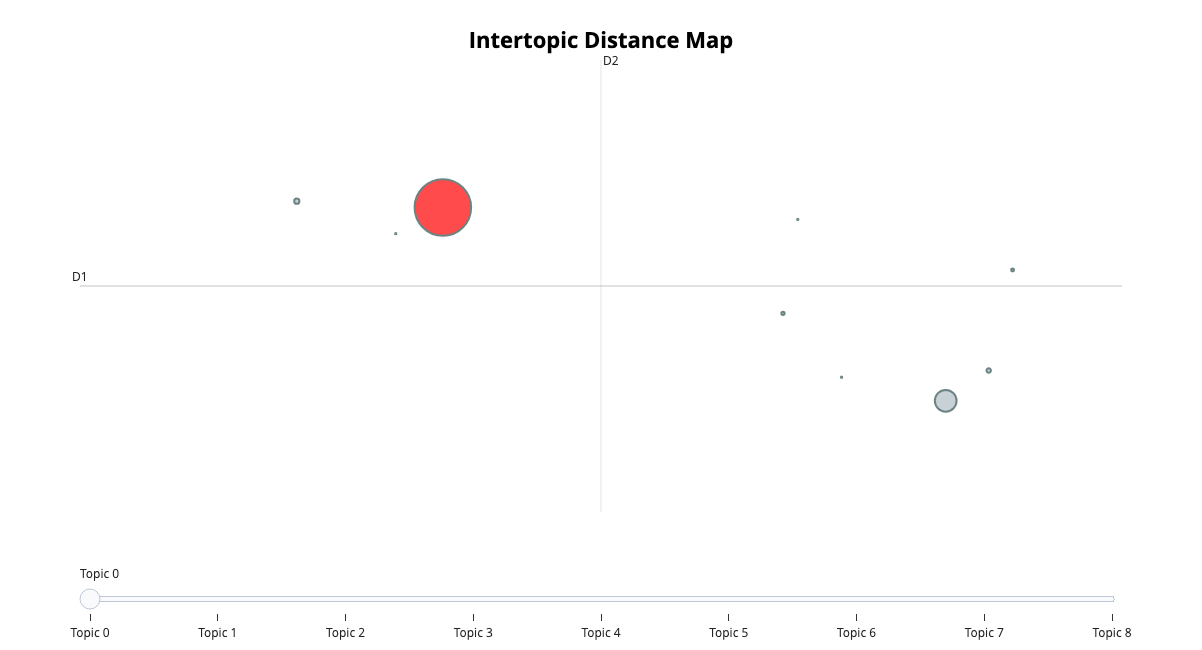

In [45]:
model2.visualize_topics()

/Users/liyenauseff/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/liyenauseff/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



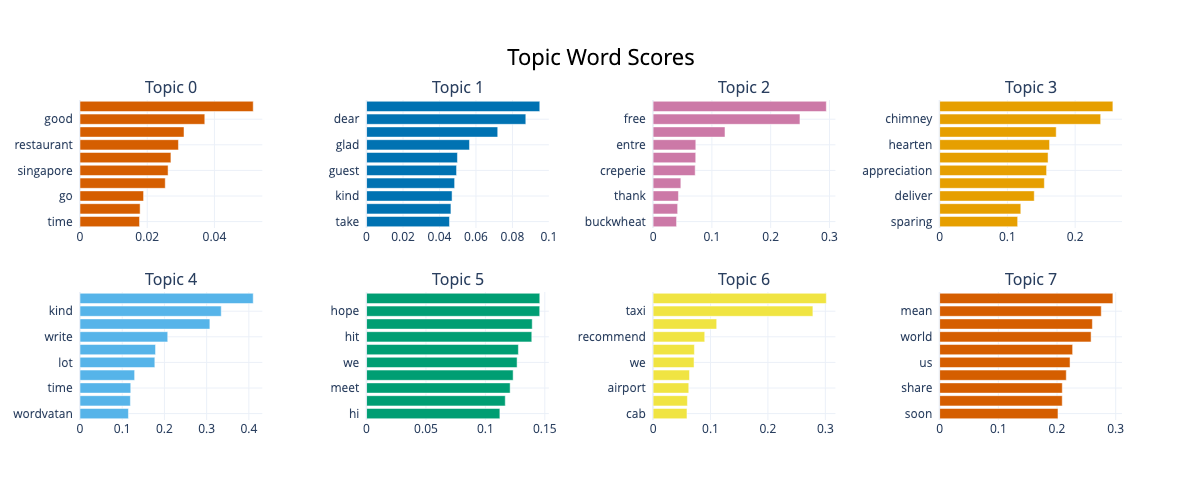

In [46]:
model2.visualize_barchart(n_words=10)

In [ ]:
%%time

labels = ['food_quality', 'service', 'ambiance', 'overall_experience']

zs_reviews = zero_shot_classisfication(reviews, 'cleaned_text_lem', labels)

In [22]:
def zero_shot_classification(df, col, labels):
    # Initialize the zero-shot classification pipeline
    new_df = df.copy()
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

    for label in labels:
        new_df[label] = 0.0  # Initialize the column with zeros for each candidate label

    for i, review_text in tqdm(enumerate(new_df[col]), desc="Processing Reviews", total=len(new_df)):
        # Perform zero-shot classification for the review text
        result = classifier(review_text, labels, multi_label=True)

        for j, label in enumerate(labels):
            new_df.at[i, label] = result['scores'][j]

    return new_df


labels = ['food_quality', 'service', 'ambiance', 'overall_experience']
zs_reviews = zero_shot_classification(reviews, 'cleaned_text_lem', labels)

/Users/liyenauseff/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/liyenauseff/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/liyenauseff/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/liyenauseff/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWar

Processing Reviews:   0%|          | 0/40942 [00:00<?, ?it/s]

In [23]:
zs_reviews.head()

,cleaned_text_lem,restaurant_label,food_quality,service,ambiance,overall_experience
0,come entre nous periodically past year seem se...,0.0,0.990804,0.974765,0.708064,0.005743
1,absolutely delicious menu lovely offer excepti...,0.0,0.984318,0.966782,0.108490,0.045861
2,thank much choose entre nous creperie recently...,0.0,0.945397,0.879296,0.871327,0.576215
3,lovely little french restaurant really authent...,0.0,0.963721,0.952793,0.695291,0.637239
4,dear rebecca thank much dining entre nous crep...,0.0,0.987780,0.970174,0.964628,0.740549


In [24]:
zs_reviews.columns

Index(['cleaned_text_lem', 'restaurant_label', 'food_quality', 'service',
       'ambiance', 'overall_experience'],
      dtype='object')

In [26]:
zs_reviews.iloc[:3,:]

,cleaned_text_lem,restaurant_label,food_quality,service,ambiance,overall_experience
0,come entre nous periodically past year seem se...,0.0,0.990804,0.974765,0.708064,0.005743
1,absolutely delicious menu lovely offer excepti...,0.0,0.984318,0.966782,0.108490,0.045861
2,thank much choose entre nous creperie recently...,0.0,0.945397,0.879296,0.871327,0.576215


In [31]:
zs_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40947 entries, 0 to 28025
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cleaned_text_lem    40942 non-null  object 
 1   restaurant_label    40942 non-null  float64
 2   food_quality        40947 non-null  float64
 3   service             40947 non-null  float64
 4   ambiance            40947 non-null  float64
 5   overall_experience  40947 non-null  float64
dtypes: float64(5), object(1)
memory usage: 3.2+ MB


In [32]:
zs_reviews[zs_reviews['restaurant_label'].isnull()]

,cleaned_text_lem,restaurant_label,food_quality,service,ambiance,overall_experience
8154,NaN,NaN,0.971621,0.945000,0.071411,0.057877
8163,NaN,NaN,0.995604,0.965937,0.961140,0.960985
8165,NaN,NaN,0.985788,0.859831,0.467956,0.066326
14905,NaN,NaN,0.987448,0.973357,0.946509,0.472281
28025,NaN,NaN,0.996197,0.988327,0.975356,0.904937


In [30]:
zs_reviews.drop(columns=['cleaned_text_lem'])

,restaurant_label,food_quality,service,ambiance,overall_experience
0,0.0,0.990804,0.974765,0.708064,0.005743
1,0.0,0.984318,0.966782,0.108490,0.045861
2,0.0,0.945397,0.879296,0.871327,0.576215
3,0.0,0.963721,0.952793,0.695291,0.637239
4,0.0,0.987780,0.970174,0.964628,0.740549
...,...,...,...,...,...
8154,NaN,0.971621,0.945000,0.071411,0.057877
8163,NaN,0.995604,0.965937,0.961140,0.960985
8165,NaN,0.985788,0.859831,0.467956,0.066326
14905,NaN,0.987448,0.973357,0.946509,0.472281


In [42]:
zs_reviews[~zs_reviews['restaurant_label'].isnull()]

,cleaned_text_lem,restaurant_label,food_quality,service,ambiance,overall_experience
0,come entre nous periodically past year seem se...,0.0,0.990804,0.974765,0.708064,0.005743
1,absolutely delicious menu lovely offer excepti...,0.0,0.984318,0.966782,0.108490,0.045861
2,thank much choose entre nous creperie recently...,0.0,0.945397,0.879296,0.871327,0.576215
3,lovely little french restaurant really authent...,0.0,0.963721,0.952793,0.695291,0.637239
4,dear rebecca thank much dining entre nous crep...,0.0,0.987780,0.970174,0.964628,0.740549
...,...,...,...,...,...,...
40942,chao serve one good authentic teochew cuisine ...,146.0,0.000000,0.000000,0.000000,0.000000
40943,love dish order suckle pig advance regret also...,146.0,0.000000,0.000000,0.000000,0.000000
40944,country famous cuisine melt nation opp restaur...,146.0,0.000000,0.000000,0.000000,0.000000
40945,make reservation highly recommend inside seat ...,146.0,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Step 1: Aggregate Scores for Each Restaurant
# Step 2: Calculate NPS for Each Classifier
# Step 3: Calculate Overall NPS for Each Restaurant
# Step 4: Interpret the Results
# Analyze the 'Overall_NPS' column in the 'average_scores' dataframe.
